# 4兆通りの足し算を同時に行う

実習の第二回では、量子コンピュータの**並列性**に着目します。前半で量子コンピュータにおける並列計算とは具体的にどういうことかを確認してから、後半で並列計算の代表的な利用例として物理系のダイナミクスシミュレーションを取り上げます。

```{contents} 目次
---
local: true
---
```

$\newcommand{ket}[1]{|#1\rangle}$

## 巨大SIMDマシンとしての量子コンピュータ

SIMD (single instruction multiple data)とは並列計算パラダイムの一つで、プロセッサの命令（instruction）が多数のデータに同時に適用されるケースを指します。私達の身の回りの（古典）コンピュータのプロセッサにもSIMD用のインストラクションセットが搭載されており、例えば（2021年2月現在）最先端の商用CPUでは、16個の単精度浮動小数点数に対し同時に四則演算や平方根の計算を行えます。

量子コンピュータでは、第一回の実習で触れられたように、すべてのゲートがすべての計算基底に作用します。ゲート操作を命令、各計算基底の振幅をデータとして解釈すれば、これは常に$2^n$個のデータに命令を与えながら計算をしていることにあたります。量子コンピュータは巨大SIMDマシンとも考えられるのです。

ただし、これもすでに触れられたことですが、巨大並列計算ができたとしても、そのデータをすべて引き出すことはできません[^and_you_dont_want_to]ので、古典計算機のSIMDとはいろいろな意味で単純に比較できるものではありません。

とはいえ、並列計算を行っているんだということを実感できると、より量子コンピュータを使う感覚が身に付いてくると思われるので、今回は最も単純に「足し算」をたくさん並列に行う回路を書いてみましょう。

[^and_you_dont_want_to]: そもそも、例えば65量子ビットの計算機からすべてのデータを保存しようと思うと、各振幅を128（古典）ビットの浮動小数点複素数で表現したとすれば512EiB (エクサバイト)のストレージが必要です。これはだいたい現在インターネットを行き来する情報二ヶ月分に相当するので、保存するファシリティを作るにはそれなりの投資が必要です。

## 量子フーリエ変換による足し算

第一回でいろいろな量子状態を作ったり課題で入力波形のフーリエ変換を行ったりしましたが、もっと単純であるはずの四則演算のやりかたについて触れていませんでした。理由は、実は量子コンピュータでは四則演算がそんなに単純でないから、です。

足し算を行う量子サブルーチンはいくつか知られていますが、その中で量子ビットの数や用いるゲートの種類の面で効率的なのが、フーリエ変換を用いたものです。ただの足し算にフーリエ変換を持ち出すのは奇妙に思えますが、実際に動かしてみるとなかなかスマートな手法であることがわかります。

まずは計算の流れを数式で追ってみましょう。整数$a$と$b$の足し算を考えます。まず、2つのレジスタをそれぞれ状態$\ket{a}$と$\ket{b}$に用意します。以下のように、第3のレジスタ（初期状態$\ket{0}$）の状態が和$a+b$を表すようにすることが目標です。それぞれのレジスタは十分に大きい（レジスタ$i$のビット数を$n_i$として$2^{n_1} > a$, $2^{n_2} > b$, $2^{n_3} > a + b$）とします。

$$
\ket{a}\ket{b}\ket{0} \rightarrow \ket{a}\ket{b}\ket{a+b}
$$

量子フーリエ変換は、ビット数$n$のレジスタの計算基底$\ket{j}$を

$$
\ket{j} \xrightarrow{\text{Q.F.T.}} \frac{1}{\sqrt{2^n}}\sum_{k=0}^{2^n-1} e^{2\pi i jk/2^n} \ket{k}
$$

という状態に変える操作でした。では、その逆を考えると、整数$a+b < 2^n$について

$$
\frac{1}{\sqrt{2^n}}\sum_{k=0}^{2^n-1} e^{2\pi i (a+b)k/2^n} \ket{k} \xrightarrow{\text{Q.F.T.}^{-1}} \ket{a+b}
$$

ができることがわかります。すべての量子ゲートには逆操作が存在するので、すべての量子サブルーチンは逆回しできます。

左辺の状態を作るには、これも量子フーリエ変換のアルゴリズムを参考にします。整数$a, b, k$の二進分解

$$
a = \sum_{m=0}^{n_1-1} 2^m a_m \\
b = \sum_{m=0}^{n_2-1} 2^m b_m \\
k = \sum_{m=0}^{n_3-1} 2^m k_m
$$

を用いて、

$$
\exp\left(2\pi i \frac{(a+b)k}{2^{n_3}}\right) = \left[\prod_{l=0}^{n_1-1}\prod_{m=0}^{n_3-1} \exp\left(2\pi i \frac{2^{l+m} a_l k_m}{2^{n_3}}\right)\right]\left[\prod_{l=0}^{n_2-1}\prod_{m=0}^{n_3-1} \exp\left(2\pi i \frac{2^{l+m} b_l k_m}{2^{n_3}}\right)\right]
$$

と書けることを利用します。つまり、レジスタ1または2の各ビットとレジスタ3の各ビットを一つずつ組み合わせて、両方のビットが1である（$a_l = k_m = 1$または$b_l = k_m = 1$の）ときに対応する分（$2\pi 2^{l + m} / 2^{n_3}$）位相を進めれば、左辺の状態ができあがります。

具体的には、まずレジスタ3をequal superpositionに用意し、レジスタ1の各ビットを制御、レジスタ3の各ビットを標的とした$C[P]$ゲートをかけていきます。

$$
\begin{align}
\ket{a}\ket{b}\ket{0} & \xrightarrow{H^{\otimes n_3}} \ket{a}\ket{b} \frac{1}{\sqrt{2^{n_3}}} \sum_{k=0}^{2^{n_3}-1} \ket{k} \\
& \xrightarrow{C^{1;0}_{3;0}[P(2\pi \cdot 2^0 \cdot 2^0/2^{n_3})]} \ket{a}\ket{b} \frac{1}{\sqrt{2^{n_3}}} \sum_{k=0}^{2^{n_3}-1} \exp \left( 2\pi i \frac{a_0 k_0}{2^{n_3}} \right) \ket{k} \\
& \xrightarrow{C^{1;0}_{3;1}[P(2\pi \cdot 2^0 \cdot 2^1/2^{n_3})]} \ket{a}\ket{b} \frac{1}{\sqrt{2^{n_3}}} \sum_{k=0}^{2^{n_3}-1} \exp \left( 2\pi i \frac{a_0 (k_0 + 2k_1)}{2^{n_3}} \right) \ket{k} \\
\cdots & \\
& \xrightarrow{C^{1;0}_{3;n_3 - 1}[P(2\pi \cdot 2^0 \cdot 2^{n_3 - 1}/2^{n_3})]} \ket{a}\ket{b} \frac{1}{\sqrt{2^{n_3}}} \sum_{k=0}^{2^{n_3}-1} \exp \left( 2\pi i \frac{a_0 k}{2^{n_3}} \right) \ket{k} \\
& \xrightarrow{C^{1;1}_{3;0}[P(2\pi \cdot 2^1 \cdot 2^0/2^{n_3})]} \ket{a}\ket{b} \frac{1}{\sqrt{2^{n_3}}} \sum_{k=0}^{2^{n_3}-1} \exp \left( 2\pi i \frac{a_0 k + 2a_1 k_0}{2^{n_3}} \right) \ket{k} \\
\cdots & \\
& \xrightarrow{C^{1;n_1 - 1}_{3;n_3 - 1}[P(2\pi \cdot 2^{n_1-1} \cdot 2^{n_3 - 1}/2^{n_3})]} \ket{a}\ket{b} \frac{1}{\sqrt{2^{n_3}}} \sum_{k=0}^{2^{n_3}-1} \exp \left( 2\pi i \frac{a k}{2^{n_3}} \right) \ket{k}
\end{align}
$$

続いてレジスタ2のビットを制御として、同様の$C[P]$ゲートをかけていくと、

$$
\begin{align}
& \xrightarrow{C^{2;0}_{3;0}[P(2\pi \cdot 2^0 \cdot 2^0/2^{n_3})]} \ket{a}\ket{b} \frac{1}{\sqrt{2^{n_3}}} \sum_{k=0}^{2^{n_3}-1} \exp \left( 2\pi i \frac{ak + b_0 k_0}{2^{n_3}} \right) \ket{k} \\
& \xrightarrow{C^{2;0}_{3;1}[P(2\pi \cdot 2^0 \cdot 2^1/2^{n_3})]} \ket{a}\ket{b} \frac{1}{\sqrt{2^{n_3}}} \sum_{k=0}^{2^{n_3}-1} \exp \left( 2\pi i \frac{ak + b_0 (k_0 + 2k_1)}{2^{n_3}} \right) \ket{k} \\
\cdots & \\
& \xrightarrow{C^{2;0}_{3;n_3 - 1}[P(2\pi \cdot 2^0 \cdot 2^{n_3 - 1}/2^{n_3})]} \ket{a}\ket{b} \frac{1}{\sqrt{2^{n_3}}} \sum_{k=0}^{2^{n_3}-1} \exp \left( 2\pi i \frac{(a + b_0) k}{2^{n_3}} \right) \ket{k} \\
& \xrightarrow{C^{2;1}_{3;0}[P(2\pi \cdot 2^1 \cdot 2^0/2^{n_3})]} \ket{a}\ket{b} \frac{1}{\sqrt{2^{n_3}}} \sum_{k=0}^{2^{n_3}-1} \exp \left( 2\pi i \frac{(a + b_0) k + 2b_1 k_0}{2^{n_3}} \right) \ket{k} \\
\cdots & \\
& \xrightarrow{C^{2;n_2 - 1}_{3;n_3 - 1}[P(2\pi \cdot 2^{n_2 - 1} \cdot 2^{n_3 - 1}/2^{n_3})]} \ket{a}\ket{b} \frac{1}{\sqrt{2^{n_3}}} \sum_{k=0}^{2^{n_3}-1} \exp \left( 2\pi i \frac{(a + b) k}{2^{n_3}} \right) \ket{k}
\end{align}
$$

となり、めでたく$\ket{a+b}$のフーリエ変換状態が実現されました。

では以上の操作をQiskitで実装してみましょう。レジスタ1と2は4ビットとして、$a=9, b=13$を考えます。後の便利のために、まずは足し算のサブルーチン部分だけを関数化します。

In [1]:
from qiskit import QuantumRegister, QuantumCircuit
import numpy as np

def setup_addition(circuit, reg1, reg2, reg3):
    """Set up an addition subroutine to a circuit with three registers
    """
    
    # Equal superposition in register 3
    circuit.h(reg3)

    # Smallest unit of phi
    dphi = 2. * np.pi / (2 ** reg3.size)

    # Loop over reg1 and reg2
    for reg_ctrl in [reg1, reg2]:
        # Loop over qubits in the control register (reg1 or reg2)
        for qctrl in reg_ctrl:
            # Loop over qubits in the target register (reg3)
            for qtarg in reg3:
                # C[P(phi)], phi = 2pi * 2^{ictrl} * 2^{itarg} / 2^{n3}
                circuit.cp(dphi * (2 ** (qctrl.index + qtarg.index)), qctrl, qtarg)

    # Insert a barrier for better visualization
    circuit.barrier()

    # Inverse QFT
    for j in range(reg3.size // 2):
        circuit.swap(reg3[j], reg3[-1 - j])

    for itarg in range(reg3.size):
        for ictrl in range(itarg):
            power = ictrl - itarg - 1 + reg3.size
            circuit.cp(-dphi * (2 ** power), reg3[ictrl], reg3[itarg])
        
        circuit.h(reg3[itarg])
        
print('Defined function setup_addition')

Defined function setup_addition


回路を作り、レジスタ1と2を入力9と13を表すように初期化します。

n1 = 4 n2 = 4 n3 = 5


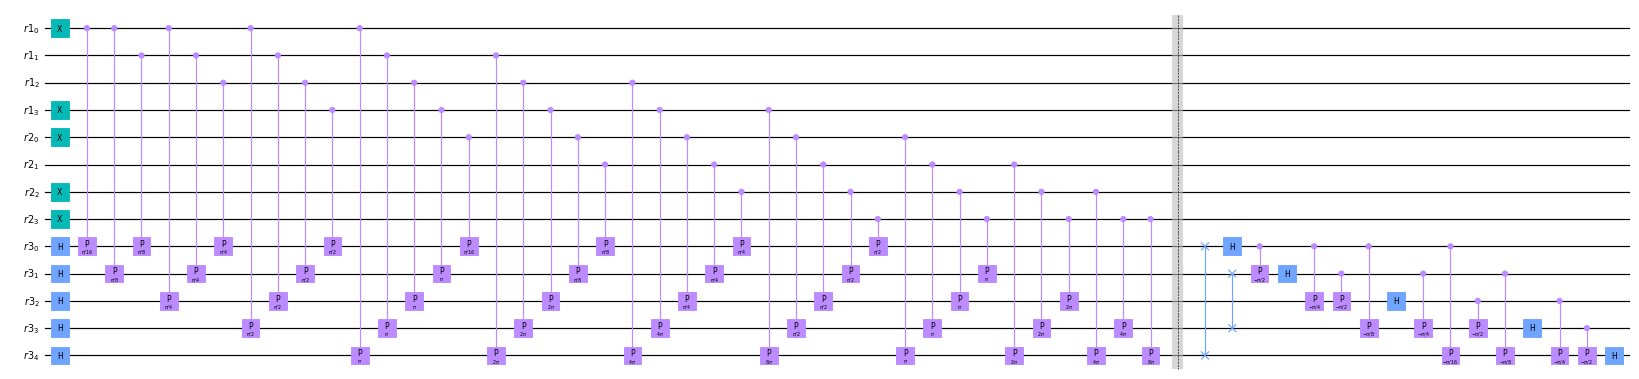

In [2]:
a = 9
b = 13

# Calculate the necessary register sizes
n1 = np.ceil(np.log2(a + 1)).astype(int)
n2 = np.ceil(np.log2(b + 1)).astype(int)
n3 = np.ceil(np.log2(a + b + 1)).astype(int)

print('n1 =', n1, 'n2 =', n2, 'n3 =', n3)

reg1 = QuantumRegister(n1, 'r1')
reg2 = QuantumRegister(n2, 'r2')
reg3 = QuantumRegister(n3, 'r3')

# QuantumCircuit can be instantiated from multiple registers
circuit = QuantumCircuit(reg1, reg2, reg3)

# Set register 1 to state |a>
for j in range(n1):
    if ((a >> j) & 1) == 1:
        circuit.x(reg1[j])

# Set register 2 to state |b>
for j in range(n2):
    if ((b >> j) & 1) == 1:
        circuit.x(reg2[j])
        
setup_addition(circuit, reg1, reg2, reg3)

circuit.draw('mpl', scale=0.6, fold=100)

再び`show_state`関数を使って終状態を確認してみましょう。

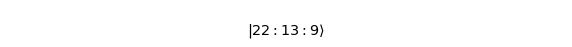

In [3]:
# Notebooks in mybinder.org starts in the root directory of the repository
import os
import sys
if 'source' in os.listdir('.'):
    sys.path.append('{}/source'.format(os.getcwd()))
    
from utils.show_state import show_state

show_state(circuit, register_sizes=(n1, n2, n3), draw=False)

ここで、`register_sizes`というオプション引数を渡して、13ビットの回路を$n_1 + n_2 + n_3$ビットに分けて解釈するよう指定しました。結果表示された状態は期待通り単一の計算基底$22:13:9$、つまりレジスタ1, 2, 3がそれぞれ$\ket{9}, \ket{13}, \ket{22}$となっている状態です（回路全体でビットを右から書いて状態を表示するため、レジスタも右から左に並びます）。つまり、めでたく状態の変遷

$$
\ket{9}\ket{13}\ket{0} \rightarrow \ket{9}\ket{13}\ket{22}
$$

が実現しました。

## 足し算の並列化

上では小学一年生ができる足し算を一回行うために13個の量子ビットと67個のゲートを利用しました。しかし、出来上がった回路は入力の値（9と13）によらず、4ビットで表現できる2つの整数すべてに対して成り立ちます（一般に2つの$n$ビット数の和は$n+1$ビットに収まるので、レジスタ3の大きさにも不足はありません）。さらに、量子演算は線形（つまり演算$U$について$U(\sum_{k} c_k \ket{k}) = \sum_{k} c_k U\ket{k}$）なので、初期状態としてレジスタ1と2がどんな計算基底の重ね合わせにあっても、それぞれの組み合わせに対してレジスタ3の状態が和を表してくれます。特に、初期状態がequal superpositionであれば、この回路は

$$
\sum_{j=0}^{2^{n_1}-1} \sum_{k=0}^{2^{n_2}-1} \ket{j}\ket{k}\ket{0} \rightarrow \sum_{j=0}^{2^{n_1}-1} \sum_{k=0}^{2^{n_2}-1} \ket{j}\ket{k}\ket{j+k}
$$

を行うので、$\mathcal{O}\left((n_1 + n_2 + n_3) n_3\right)$個のゲートで$2^{n_1+n_2}$通りの足し算を並列に行います。実際にこれを確認してみましょう。

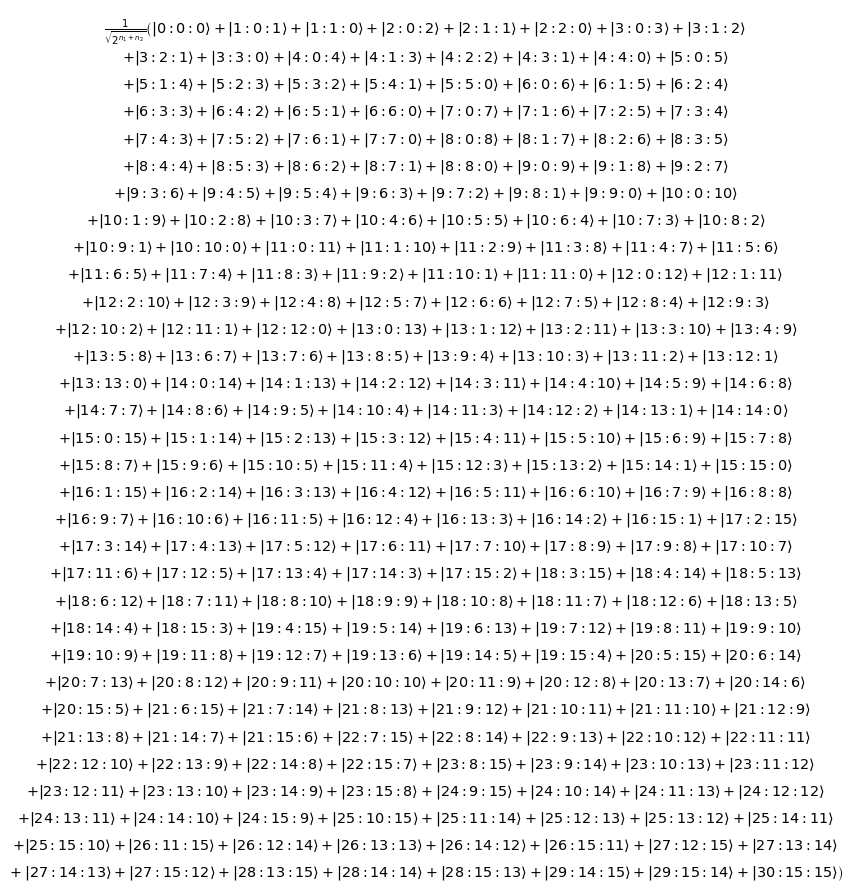

In [4]:
n1 = 4
n2 = 4
n3 = np.ceil(np.log2((2 ** n1) + (2 ** n2) - 1)).astype(int)

reg1 = QuantumRegister(n1, 'r1')
reg2 = QuantumRegister(n2, 'r2')
reg3 = QuantumRegister(n3, 'r3')

# QuantumCircuit can be instantiated from multiple registers
circuit = QuantumCircuit(reg1, reg2, reg3)

# Set register 1 and 2 to equal superpositions
circuit.h(reg1)
circuit.h(reg2)
        
setup_addition(circuit, reg1, reg2, reg3)

show_state(circuit, register_sizes=(n1, n2, n3), amp_norm=(1. / np.sqrt(2 ** (n1 + n2)), r'\frac{1}{\sqrt{2^{n_1 + n_2}}}'), draw=False)

65量子ビットのマシンを最大限利用するならば、$n_1 = n_2 = 21, n_3 = 22$で$2^{42}$通り、つまり約4兆通りの足し算を同時に行うことができます。

もちろん、上で書いたようにここには重要な但し書きがあって、実機でこの計算をして測定から答えを得ようとすると、毎回の測定でどの組み合わせが得られるかをコントロールできないので、これはあまり実用的とは言えない回路です。強いて言えば毎日ランダムに6桁＋6桁の正しい足し算を教えてくれる「日めくり足し算カレンダー」にくらいは使えます。4兆通りなので100億年程度使い続けられます。

## 実機での実行

上の足し算回路の結果がランダムに出る様子をシミュレーションと実機で確認しましょう。ただし、上の実装では非効率的でエラーが出すぎるので、[こちらの効率化した回路](https://github.com/UTokyo-ICEPP/qc-workbook/tree/master/source/utils/optimized_additions.py)を代わりに使用します。

In [5]:
from utils.optimized_additions import optimized_additions

# 実機で実行するために、元の回路に測定を加える
circuit.measure_all()
circuit_original = circuit

# 効率化した回路（測定付き）
circuit_optimized = optimized_additions(n1, n2)

回路の効率化とは具体的にどういうことでしょうか。もともとの回路と効率化したものとを比べてみましょう。まずは、単純にオペレーションの数を比較します。ゲート一つ一つで一定の確率でエラーが起こるということは、同じことをする回路ならゲートの数が少ないほうがより正確な計算をしてくれます。

In [6]:
print('Number of operations in the original circuit:', circuit_original.size())
print('Number of operations in the optimized circuit:', circuit_optimized.size())

Number of operations in the original circuit: 83
Number of operations in the optimized circuit: 331


効率化したはずの回路のほうがはるかにゲート数が多いという結果になりました。なぜでしょうか。

### トランスパイルと物理的回路

{doc}`circuit_from_scratch`でも少し触れましたが、回路が実機で実行される前には、トランスパイルという回路の変換が行われ、様々な組み合わせゲートからなる「論理的」な回路から、実機のハードウェアに実装されている基本ゲートのみで書かれる「物理的」な回路が作られます[^physical]。論理的な回路はどのようにでも書ける（例えば回路全体を一つのゲートと呼んでしまうこともできる）ので、回路の効率の比較はトランスパイル後でなければ意味がありません。

いい機会なので、実機での量子計算について少し詳細に考えてみましょう。トランスパイルがまさに論理的なアルゴリズムの世界と物理的実装の世界のインターフェースとなるので、この過程に注目します。

トランスパイル時には、以下のような回路の変換が起こります。

- 冗長なゲートの削除
- 多重制御ゲートのCNOTと1量子ビットゲートへの分解
- 実機のトポロジーに即した量子ビットのマッピング（詳細は下）
- 物理的に隣接しない量子ビット間の制御ゲートを実行するためのSWAPの挿入
- 1量子ビットゲートの基本ゲートへの分解
- 物理的回路の最適化

実機のトポロジーとは、実際の量子プロセッサチップ上での量子ビット同士の繋がりかたのことを指します。2つの量子ビットが繋がっているとは、その間で基本制御ゲート（IBMQではCNOT）が実行できるということを意味します。これまで考慮してきませんでしたが、実はすべての量子ビットが繋がっているわけではないのです。例えば後で使うibmq_16_melbourneというマシンは以下のようなトポロジーを持っています。

```{image} figs/melbourne_topology.png
:height: 200px
:name: ibmq_16_melbourne
```

図中、数字のついた丸が量子ビットを表し、線が量子ビット同士の繋がりを表します。

直接接続のない量子ビット間で制御ゲートを実行する場合、SWAPを使って2つの量子ビットが隣り合うように状態を遷移させていく必要があります。例えば上のibmq_16_melbourneでビット2と6の間のCNOTが必要なら、（いくつか方法がありますが）2↔3, 3↔4, 4↔5とSWAPを繰り返して、5と6の間でCNOTを行い、ビットの並びを元に戻す必要があれば再度5↔4, 4↔3, 3↔2とSWAPをすることになります。

{ref}`ゲートの解説 <other_single_and_double_qubit_gates>`に出てきたように、SWAPは3つのCNOTに分解されます。つまり、直接接続のない量子ビット同士の制御ゲートが多出するような回路があると、莫大な数のCNOTが使われることになります。**CNOTのエラーレートは1量子ビットゲートのエラーレートより一桁ほど高い**ので、これは大きな問題になります。そこで、論理的回路の量子ビットと実機の量子ビットとのマッピング（SWAPが発生すれば対応は変わっていくので、あくまで初期対応）と、回路中にどうSWAPを挿入していくかというルーティングの両方を上手に決めるということが、トランスパイルにおける中心的な課題です。

しかし、実は一般の回路に対して最適なマッピングとルーティングを探すという問題自体がいわゆるNP-hardな問題なので、qiskitのトランスパイル・ルーチンではこの問題の最適解を探してくれません。代わりにstochastic swapという、乱数を用いた手法が標準設定では利用されます。Stochastic swapは多くの回路で比較的効率のいいルーティングを作ることが知られていますが、乱数を利用するため実行のたびに異なるルーティングが出てくるなど、やや扱いにくい面もあります。また、単純な回路で事前に最適なルーティングがわかっている場合は、stochastic swapを使うべきではありません。

### 回路の比較

上を踏まえて、改めて2つの足し算回路を比較してみましょう。

これまで実機で回路を実行するときは`execute`という関数を利用していましたが、実はこの関数にトランスパイル前の回路を渡すと、自動で標準設定のトランスパイルがなされていました。しかし`transpile`という関数を使い、トランスパイルを明示的に行うこともできます。この関数は主にトランスパイルの設定を細かくコントロールしたいときなどに使います。今回の効率化した回路は特定のマッピングのために作られているので、stochastic swapを使用しないよう設定を変更してトランスパイルをします。

IBMQのマシンはチップごとに異なるトポロジーを持っているので、`transpile`関数にも引数としてバックエンドを指定し、そのバックエンド専用の物理的回路を作ります。

[^physical]: 「物理的」な回路もまだ実は論理的な存在であり、本当にハードウェアが理解するインストラクションに変換するには、さらに基本ゲートを特定のマイクロ波パルス列に直す必要があります。

In [7]:
from qiskit import IBMQ, transpile

IBMQ.enable_account('__paste_your_token_here__')

provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

# 4 + 4 + 5 = 13量子ビット以上のマシンで ibm-q/open/main からアクセス可能なのはibmq_16_melbourneのみ（2021年3月現在）
backend = provider.get_backend('ibmq_16_melbourne')

# オリジナルの回路をトランスパイルする。optimization_level=3は自動設定のうち、最も効率のいい回路を作る
print('Transpiling the original circuit with standard settings')
circuit_original_tr = transpile(circuit_original, backend=backend, optimization_level=3)

# 効率化した回路をトランスパイルする。ibmq_16_melbourneのうち、一直線に繋がった量子ビット列にマッピングする
print('Transpiling the optimized circuit with basic routing and custom qubit mapping')
initial_layout = [1, 0, 14, 13, 12, 11, 10, 9, 8, 6, 5, 4, 3]
circuit_optimized_tr = transpile(circuit_optimized, backend=backend, routing_method='basic', initial_layout=initial_layout, optimization_level=3)

print('Number of operations in the original circuit:', circuit_original_tr.size())
print('  Breakdown: N(Rz)={rz}, N(SX)={sx}, N(CNOT)={cx}'.format(**circuit_original_tr.count_ops()))
print('Number of operations in the optimized circuit:', circuit_optimized_tr.size())
print('  Breakdown: N(Rz)={rz}, N(SX)={sx}, N(CNOT)={cx}'.format(**circuit_optimized_tr.count_ops()))

/usr/local/lib/python3.8/dist-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


Transpiling the original circuit with standard settings
Transpiling the optimized circuit with basic routing and custom qubit mapping
Number of operations in the original circuit: 790
  Breakdown: N(Rz)=300, N(SX)=220, N(CNOT)=257
Number of operations in the optimized circuit: 369
  Breakdown: N(Rz)=146, N(SX)=68, N(CNOT)=142


```{tip}
上のように`optimization_level=3`でトランスパイルをすると、回路の最適化ルーチンに時間がかかりすぎることがたまにあります。セルを実行して1分以上反応がない場合は、一度Jupyterのカーネルを再起動してみてください。
```

上のセルを実行すると、今度は効率化回路のオペレーションの数が元の回路の半数以下という結果になることがわかります。このマシンの基本ゲート$R_z, X$, SX, CNOTに分解した内訳でも、エラーの多いCNOTゲートの数が大幅に削減されています（両回路とも$X$ゲートは0個です）。

元の回路と効率化した回路の違いは、後者では「数珠つなぎ」になった量子ビット列というトポロジーを仮定して、制御ゲートの順番を工夫して直接明示的にSWAPを挿入していることです。さらに、可能なところでは$C[P]$ゲートの分解で生じるCNOTとSWAPのCNOTが打ち消し合うことも利用しています。最後の逆フーリエ変換でもゲートの順番が工夫してあります。

それでは、トランスパイルした回路を実行してみます。まずはシミュレータで理想的な結果を確認しましょう。`transpile`関数を使って「手動で」トランスパイルを行った回路を`execute`に渡すと再び標準設定でトランスパイルされてしまうので、別の手続きを踏みます。

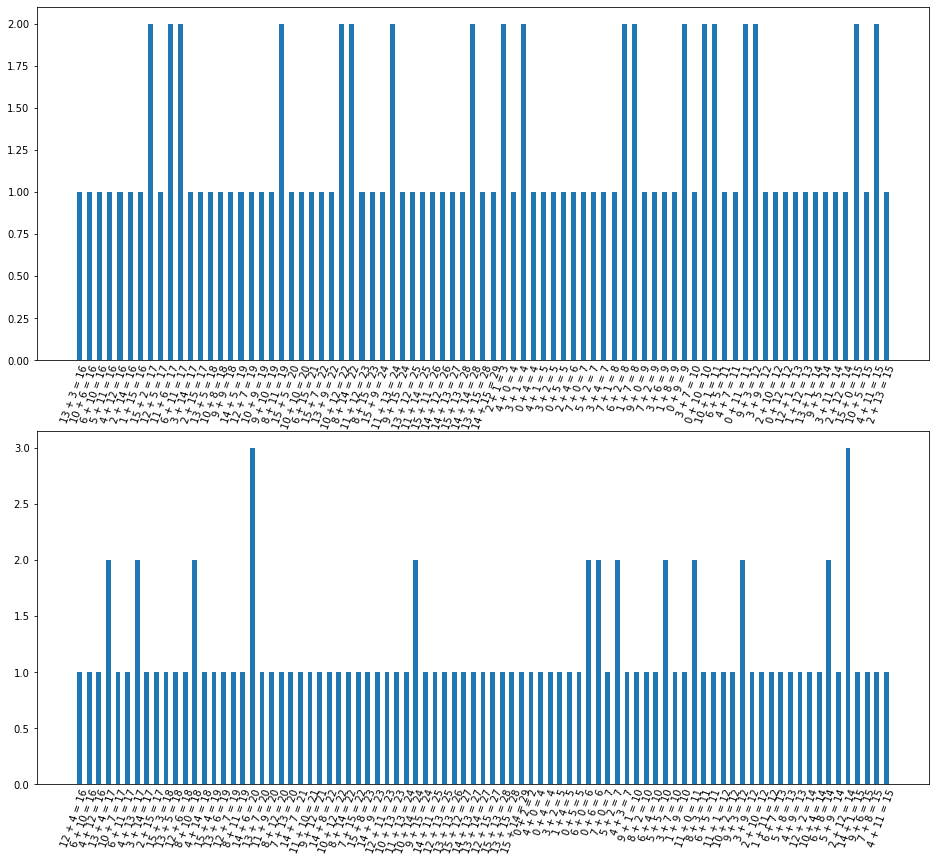

In [8]:
from qiskit import Aer, assemble
import matplotlib.pyplot as plt

qasm_simulator = Aer.get_backend('qasm_simulator')

# Will call assemble() and backend.run() instead of execute()
qobj_original = assemble(circuit_original_tr, backend=qasm_simulator, shots=100)
job_original = qasm_simulator.run(qobj_original)
counts_original = job_original.result().get_counts()

qobj_optimized = assemble(circuit_optimized_tr, backend=qasm_simulator, shots=100)
job_optimized = qasm_simulator.run(qobj_optimized)
counts_optimized = job_optimized.result().get_counts()

# Keys of counts are single binaries; need to split them into three parts and interpret as decimals
def interpret_counts(counts, n1, n2):
    heights = []
    labels = []

    for key, value in counts.items():
        heights.append(value)

        x1 = int(key[-n1:], 2)
        x2 = int(key[-n1 - n2:-n1], 2)
        x3 = int(key[:-n1 - n2], 2)
        labels.append('{} + {} = {}'.format(x1, x2, x3))
        
    return np.linspace(0., len(labels), len(labels), endpoint=False), heights, labels

fig, (ax_original, ax_optimized) = plt.subplots(2, figsize=[16, 10])

x, heights, labels = interpret_counts(counts_original, n1, n2)
ax_original.bar(x, heights, width=0.5)
ax_original.set_xticks(x - 0.5)
ax_original.set_xticklabels(labels, rotation=70)
ax_original.tick_params('x', length=0.)

x, heights, labels = interpret_counts(counts_optimized, n1, n2)
ax_optimized.bar(x, heights, width=0.5)
ax_optimized.set_xticks(x - 0.5)
ax_optimized.set_xticklabels(labels, rotation=70)
ax_optimized.tick_params('x', length=0.)

fig.subplots_adjust(bottom=-0.2)

正しい足し算の式がランダムに出現することを確認してください。最後に実機にジョブを投げますが、実は効率化した回路でもまだゲートの数が多すぎて答えがスクランブルされてしまいます。回路が小規模になればそれだけ成功確率も上がりますので、$(n_1, n_2)$の値として(4, 4)以外に(3, 3)、(2, 2)、(1, 1)も同時に試すことにしましょう。

In [9]:
from qiskit import ClassicalRegister
from qiskit.tools.monitor import job_monitor

# A wrapper function to define a circuit with the original implementation of additions given n1 and n2
def make_original_circuit(n1, n2):
    n3 = np.ceil(np.log2((2 ** n1) + (2 ** n2) - 1)).astype(int)

    reg1 = QuantumRegister(n1, 'r1')
    reg2 = QuantumRegister(n2, 'r2')
    reg3 = QuantumRegister(n3, 'r3')
    creg = ClassicalRegister(n1 + n2 + n3)

    # QuantumCircuit can be instantiated from multiple registers
    circuit = QuantumCircuit(reg1, reg2, reg3, creg)

    # Set register 1 and 2 to equal superpositions
    circuit.h(reg1)
    circuit.h(reg2)

    setup_addition(circuit, reg1, reg2, reg3)
    
    for ibit in range(creg.size):
        circuit.measure(ibit, ibit)
        
    return circuit

# List of circuits
circuits = []

for n1, n2 in [(4, 4), (3, 3), (2, 2), (1, 1)]:
    print('Original circuit with n1, n2 = {}, {}'.format(n1, n2))
    circuit = make_original_circuit(n1, n2)
    print('  Transpiling..')
    circuit = transpile(circuit, backend=backend, optimization_level=3)
    print('  Done. Ops: N(Rz)={rz}, N(SX)={sx}, N(CNOT)={cx}'.format(**circuit.count_ops()))
    circuit.name = 'original_{}_{}'.format(n1, n2)
    circuits.append(circuit)

    print('Optimized circuit with n1, n2 = {}, {}'.format(n1, n2))    
    circuit = optimized_additions(n1, n2)

    print('  Transpiling..')
    if n1 + n2 == 8:
        initial_layout = [1, 0, 14, 13, 12, 11, 10, 9, 8, 6, 5, 4, 3]
    elif n1 + n2 == 6:
        initial_layout = [6, 8, 9, 10, 4, 3, 2, 1, 0, 14]
    elif n1 + n2 == 4:
        initial_layout = [6, 8, 9, 10, 11, 12, 13]
    elif n1 + n2 == 2:
        initial_layout = [9, 10, 11, 12]

    circuit = transpile(circuit, backend=backend, routing_method='basic', initial_layout=initial_layout, optimization_level=3)
    print('  Done. Ops: N(Rz)={rz}, N(SX)={sx}, N(CNOT)={cx}'.format(**circuit.count_ops()))
    circuit.name = 'optimized_{}_{}'.format(n1, n2)
    circuits.append(circuit)

print('Submitting {} circuits to {}'.format(len(circuits), backend.name()))
qobj = assemble(circuits, backend=backend, shots=8192)    
job = backend.run(qobj)

job_monitor(job, interval=2)

counts_list = job.result().get_counts()

Original circuit with n1, n2 = 4, 4
  Transpiling..
  Done. Ops: N(Rz)=356, N(SX)=302, N(CNOT)=221
Optimized circuit with n1, n2 = 4, 4
  Transpiling..
  Done. Ops: N(Rz)=146, N(SX)=68, N(CNOT)=142
Original circuit with n1, n2 = 3, 3
  Transpiling..
  Done. Ops: N(Rz)=205, N(SX)=161, N(CNOT)=140
Optimized circuit with n1, n2 = 3, 3
  Transpiling..
  Done. Ops: N(Rz)=97, N(SX)=50, N(CNOT)=84
Original circuit with n1, n2 = 2, 2
  Transpiling..
  Done. Ops: N(Rz)=102, N(SX)=84, N(CNOT)=68
Optimized circuit with n1, n2 = 2, 2
  Transpiling..
  Done. Ops: N(Rz)=57, N(SX)=35, N(CNOT)=41
Original circuit with n1, n2 = 1, 1
  Transpiling..
  Done. Ops: N(Rz)=33, N(SX)=26, N(CNOT)=15
Optimized circuit with n1, n2 = 1, 1
  Transpiling..
  Done. Ops: N(Rz)=26, N(SX)=16, N(CNOT)=13
Submitting 8 circuits to ibmq_16_melbourne


ジョブが返ってきたら、8192ショットのうち正しい足し算を表しているものがどれだけあるか調べてみましょう。

In [10]:
import pickle
with open('data/parallel_additions_melbourne.pkl', 'rb') as source:
    counts_list = pickle.load(source)

In [11]:
def count_correct_additions(counts_list, n1, n2):
    for counts, ctype in zip(counts_list, ['Original ', 'Optimized']):
        correct_additions = 0

        for key, value in counts.items():
            x1 = int(key[-n1:], 2)
            x2 = int(key[-n1 - n2:-n1], 2)
            x3 = int(key[:-n1 - n2], 2)

            if x1 + x2 == x3:
                correct_additions += value
            
        print('{} circuit ({}, {}): {} / 8192 = {}'.format(ctype, n1, n2, correct_additions, correct_additions / 8192.))

icirc = 0
for n1, n2 in [(4, 4), (3, 3), (2, 2), (1, 1)]:
    count_correct_additions(counts_list[icirc:icirc + 2], n1, n2)
    icirc += 2

Original  circuit (4, 4): 293 / 8192 = 0.0357666015625
Optimized circuit (4, 4): 261 / 8192 = 0.0318603515625
Original  circuit (3, 3): 548 / 8192 = 0.06689453125
Optimized circuit (3, 3): 519 / 8192 = 0.0633544921875
Original  circuit (2, 2): 1040 / 8192 = 0.126953125
Optimized circuit (2, 2): 1394 / 8192 = 0.170166015625
Original  circuit (1, 1): 4175 / 8192 = 0.5096435546875
Optimized circuit (1, 1): 5389 / 8192 = 0.6578369140625


回路が均一にランダムに$0$から$2^{n_1 + n_2 + n_3} - 1$までの数を返す場合、レジスタ1と2のそれぞれの値の組み合わせに対して正しいレジスタ3の値が一つあるので、正答率は$2^{n_1 + n_2} / 2^{n_1 + n_2 + n_3} = 2^{-n_3}$となります。実機の結果と比べてみると、(4, 4), (3, 3), (2, 2)では残念ながら元の回路も効率化した回路も正答率がほとんどこの値に近くなっているのがわかります。かろうじて(1, 1)において正答率がランダムなケース（$2^{-2}$）より高くなっています。

### Quantum Volume

実は上のテストをIBMの提供するより高性能なマシンで実行すると、元の回路と効率化した回路とで正答率が異なることが見えます。$(n_1, n_2)$ = (1, 1)に関しては効率化回路のほうがCNOTが少しだけ多くなるケースがあり、その場合実際に元の回路の正答率のほうが高くなります。例としてibmq_torontoというマシンで実行した結果は以下のとおりです。

In [12]:
message = '''Original circuit with n1, n2 = 4, 4
  Transpiling..
  Done. Ops: N(Rz)=370, N(SX)=313, N(CNOT)=290
Optimized circuit with n1, n2 = 4, 4
  Transpiling..
  Done. Ops: N(Rz)=142, N(SX)=71, N(CNOT)=142
Original circuit with n1, n2 = 3, 3
  Transpiling..
  Done. Ops: N(Rz)=203, N(SX)=164, N(CNOT)=183
Optimized circuit with n1, n2 = 3, 3
  Transpiling..
  Done. Ops: N(Rz)=95, N(SX)=53, N(CNOT)=84
Original circuit with n1, n2 = 2, 2
  Transpiling..
  Done. Ops: N(Rz)=104, N(SX)=74, N(CNOT)=81
Optimized circuit with n1, n2 = 2, 2
  Transpiling..
  Done. Ops: N(Rz)=60, N(SX)=35, N(CNOT)=41
Original circuit with n1, n2 = 1, 1
  Transpiling..
  Done. Ops: N(Rz)=36, N(SX)=30, N(CNOT)=12
Optimized circuit with n1, n2 = 1, 1
  Transpiling..
  Done. Ops: N(Rz)=25, N(SX)=14, N(CNOT)=13
'''
print(message)

Original circuit with n1, n2 = 4, 4
  Transpiling..
  Done. Ops: N(Rz)=370, N(SX)=313, N(CNOT)=290
Optimized circuit with n1, n2 = 4, 4
  Transpiling..
  Done. Ops: N(Rz)=142, N(SX)=71, N(CNOT)=142
Original circuit with n1, n2 = 3, 3
  Transpiling..
  Done. Ops: N(Rz)=203, N(SX)=164, N(CNOT)=183
Optimized circuit with n1, n2 = 3, 3
  Transpiling..
  Done. Ops: N(Rz)=95, N(SX)=53, N(CNOT)=84
Original circuit with n1, n2 = 2, 2
  Transpiling..
  Done. Ops: N(Rz)=104, N(SX)=74, N(CNOT)=81
Optimized circuit with n1, n2 = 2, 2
  Transpiling..
  Done. Ops: N(Rz)=60, N(SX)=35, N(CNOT)=41
Original circuit with n1, n2 = 1, 1
  Transpiling..
  Done. Ops: N(Rz)=36, N(SX)=30, N(CNOT)=12
Optimized circuit with n1, n2 = 1, 1
  Transpiling..
  Done. Ops: N(Rz)=25, N(SX)=14, N(CNOT)=13



In [7]:
message = '''Original  circuit (4, 4): 289 / 8192 = 0.0352783203125
Optimized circuit (4, 4): 340 / 8192 = 0.04150390625
Original  circuit (3, 3): 531 / 8192 = 0.0648193359375
Optimized circuit \x1b[31m(3, 3)\x1b[0m: 960 / 8192 = \x1b[31m0.1171875\x1b[0m
Original  circuit (2, 2): 1250 / 8192 = 0.152587890625
Optimized circuit \x1b[31m(2, 2)\x1b[0m: 1984 / 8192 = \x1b[31m0.2421875\x1b[0m
Original  circuit \x1b[31m(1, 1)\x1b[0m: 6114 / 8192 = \x1b[31m0.746337890625\x1b[0m
Optimized circuit \x1b[31m(1, 1)\x1b[0m: 5288 / 8192 = \x1b[31m0.6455078125\x1b[0m
'''
print(message)

Original  circuit (4, 4): 289 / 8192 = 0.0352783203125
Optimized circuit (4, 4): 340 / 8192 = 0.04150390625
Original  circuit (3, 3): 531 / 8192 = 0.0648193359375
Optimized circuit (3, 3): 960 / 8192 = 0.1171875
Original  circuit (2, 2): 1250 / 8192 = 0.152587890625
Optimized circuit (2, 2): 1984 / 8192 = 0.2421875
Original  circuit (1, 1): 6114 / 8192 = 0.746337890625
Optimized circuit (1, 1): 5288 / 8192 = 0.6455078125



効率化した回路では(3, 3)の段階（回路3）で、すでに正答率が$2^{-4}$を大きく上回っているのがわかります。

IBMQでは量子コンピュータ一つ一つをQuantum Volume（QV、量子体積）という指標で評価しています[^qv]。QVは簡単に言えば「量子コンピュータ上である特定の形を持った回路を安定的に実行できる量子ビット数と回路の長さ」を測っていて、QVの値が大きいマシンほど高性能と言えます。QVは全体の量子ビット数だけではなく、量子ビット間の接続度合い、（特に制御ゲートの）エラーレート、トランスパイラの性能などを総合的に評価します。

2021年3月現在、IBMQのマシンでQVの最大値は128ですが、ibmq_16_melbourneのQVは8です。QVの値は2の実効量子ビット数乗と考えればよく、これはつまり（かなり乱暴に言うと）15ビットマシンibmq_16_melbourneの上で信頼度高く実行できるのは3量子ビット回路までだということを意味します。

上で利用したibmq_torontoのQVは32でした。量子ビット数が少ないマシンであればopenのアカウントでもQV=32のマシンが複数存在するので、最後にそのどれかを使って$(n_1, n_2)$ = (1, 1)の足し算を走らせてみましょう。

[^qv]: QVはハードウェアの詳細に依存しないように定義されているので、量子ビット型の量子コンピュータであればIBMのマシンに限らずすべてQVで評価できます。実際、業界で徐々にQVを標準ベンチマークとして使う動きが広がってきているようです。

In [16]:
from qiskit.providers.ibmq import least_busy

backend_filter = lambda b: (not b.configuration().simulator) and b.configuration().n_qubits >= 4 and b.configuration().quantum_volume >= 32 and b.status().operational
backend = least_busy(provider.backends(filters=backend_filter))

print('Using backend', backend.name())

n1 = n2 = 1

circuits = []

print('Original circuit with n1, n2 = {}, {}'.format(n1, n2))
circuit = make_original_circuit(n1, n2)
print('  Transpiling..')
circuit = transpile(circuit, backend=backend, optimization_level=3)
print('  Done. Ops: N(Rz)={rz}, N(SX)={sx}, N(CNOT)={cx}'.format(**circuit.count_ops()))
circuit.name = 'original_{}_{}'.format(n1, n2)
circuits.append(circuit)

print('Optimized circuit with n1, n2 = {}, {}'.format(n1, n2))    
circuit = optimized_additions(n1, n2)
print('  Transpiling..')
circuit = transpile(circuit, backend=backend, routing_method='basic', initial_layout=[0, 1, 2, 3], optimization_level=3)
print('  Done. Ops: N(Rz)={rz}, N(SX)={sx}, N(CNOT)={cx}'.format(**circuit.count_ops()))
circuit.name = 'optimized_{}_{}'.format(n1, n2)
circuits.append(circuit)

print('Submitting circuits')
qobj = assemble(circuits, backend=backend, shots=8192)    
job = backend.run(qobj)

job_monitor(job, interval=2)

counts_list = job.result().get_counts()

count_correct_additions(counts_list, n1, n2)

Using backend ibmq_athens
Original circuit with n1, n2 = 1, 1
  Transpiling..
  Done. Ops: N(Rz)=40, N(SX)=28, N(CNOT)=21
Optimized circuit with n1, n2 = 1, 1
  Transpiling..
  Done. Ops: N(Rz)=26, N(SX)=16, N(CNOT)=13
Submitting circuits
Job Status: job has successfully run


ibmq_16_melbourneを使った場合と比べて、正答率はどうでしょうか？